In [1]:
#This is our main program
#importing various libraries and modules

import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import logging
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
from rbm.rbm import RBM
from datasets.python_splitters import numpy_stratified_split
from datasets.sparse import AffinityMatrix
from utils.timer import Timer
from utils.plot import line_graph
from datasets import movielens 
from evaluation.python_evaluation import ( map_at_k, ndcg_at_k, precision_at_k, recall_at_k,)
%load_ext autoreload
%autoreload 2
print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.2.4
Tensorflow version: 2.3.0


In [2]:
#We firstly create a dataframe for data size 100k
#This part will download data of required size for us, convert it to dataframe and print 5 rows

MOVIELENS_DATA_SIZE = '100k'
mldf_100k = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
) 
mldf_100k.head()

100%|██████████| 4.81k/4.81k [00:25<00:00, 192KB/s]


,userID,movieID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [3]:
#Then we load data of size 1m

MOVIELENS_DATA_SIZE = '1m'
mldf_1m = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
)
mldf_1m.head()

100%|██████████| 5.78k/5.78k [00:26<00:00, 218KB/s]


,userID,movieID,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291


In [4]:
#This is to make the conventions between the module common

header = {
        "col_user": "userID",
        "col_item": "movieID",
        "col_rating": "rating",
    }

In [5]:
#This part will initiate a class "AffinityMatrix" and then generate a matrix for 1m dataset

am1m = AffinityMatrix(df = mldf_1m, **header)
X1m, _, _ = am1m.gen_affinity_matrix()

Matrix generated, sparseness percentage: 95


In [6]:
#This will split it into test and train test

Xtr_1m, Xtst_1m = numpy_stratified_split(X1m)

[Text(0.5, 0, 'ratings'), Text(0, 0.5, 'density')]

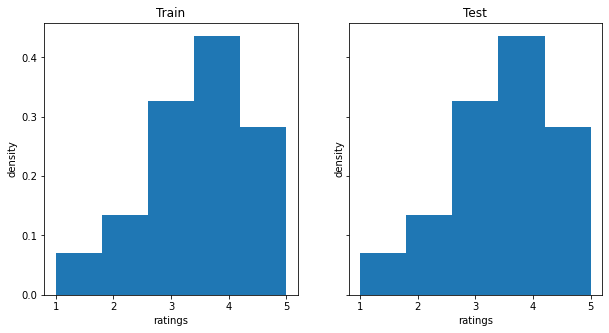

In [7]:
#This will plot a density vs rating graph to the most preferred rating for 1m data
#This part is for illustration of dataset only

_, (ax1m, ax2m) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1m.hist(Xtr_1m[Xtr_1m !=0], 5, density= True)
ax1m.set_title('Train')
ax1m.set(xlabel="ratings", ylabel="density")
ax2m.hist(Xtst_1m[Xtst_1m !=0], 5, density= True)
ax2m.set_title('Test')
ax2m.set(xlabel="ratings", ylabel="density")

In [8]:
#This part will initiate a class "AffinityMatrix" and then generate a matrix for 100k dataset
#It will then split it into test and train set

am100k = AffinityMatrix(df = mldf_100k, **header)
X100k, _, _= am100k.gen_affinity_matrix()
Xtr_100k, Xtst_100k = numpy_stratified_split(X100k)

Matrix generated, sparseness percentage: 93


[Text(0.5, 0, 'ratings'), Text(0, 0.5, 'density')]

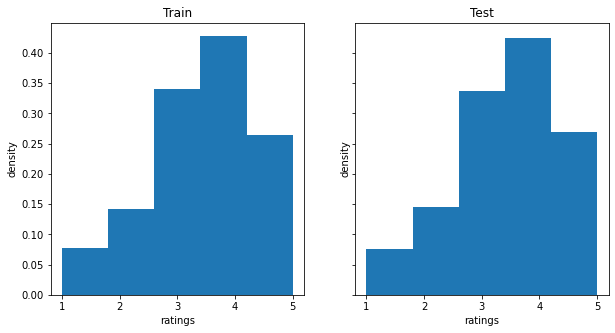

In [9]:
#This will plot a density vs rating graph to the most preferred rating for 100k data
#This part is for illustration of dataset only

_, (ax1k, ax2k) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1k.hist(Xtr_100k[Xtr_100k !=0], 5, density= True)
ax1k.set_title('Train')
ax1k.set(xlabel="ratings", ylabel="density")
ax2k.hist(Xtst_100k[Xtst_100k !=0], 5, density= True)
ax2k.set_title('Test')
ax2k.set(xlabel="ratings", ylabel="density")

In [10]:
#This function will create a dataset with row containing evaluation parameters
#These parameters are mean average precision, normalized discounted cumulative gain for k, precision for k and recall for k

def ranking_metrics(data_size, data_true, data_pred, K):
    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)
    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)
    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
        }, 
        index=[0]
    )
    return df_result

In [11]:
#This will initiate an RBM model for 1m data

model_1m = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr_1m), np.array([0])),
    visible_units=Xtr_1m.shape[1],
    hidden_units=1200,
    training_epoch=30,
    minibatch_size=350,
    with_metrics=True
)

Creating the computational graph
Initialize Gibbs protocol


training epoch 0 rmse 1.684005
training epoch 10 rmse 1.629187
training epoch 20 rmse 1.589981
training epoch 30 rmse 1.561749
Took 150.58 seconds for training.


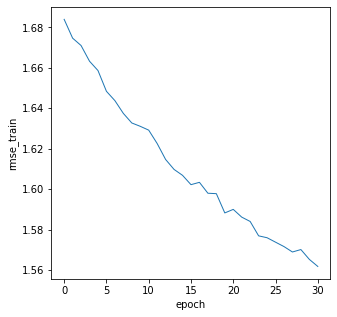

In [12]:
#This will use the affinity matrix to make a neural network for 1m data
#Also, it will print epoch vs rmse graph

with Timer() as train_time:
    model_1m.fit(Xtr_1m)
print("Took {:.2f} seconds for training.".format(train_time.interval))
line_graph(values=model_1m.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [13]:
#This will return top k cecommendations for any user from 1m dataset

K = 10
with Timer() as prediction_time:
    top_k_1m =  model_1m.recommend_k_items(Xtst_1m)
print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

Extracting top 10 elements
Took 4.85 seconds for prediction.


In [14]:
#Map back 1m dataframe to affinity matrix for both test and train data

top_k_df_1m = am1m.map_back_sparse(top_k_1m, kind = 'prediction')
test_df_1m = am1m.map_back_sparse(Xtst_1m, kind = 'ratings')

In [15]:
#It will call evaluation functions to show the exact results for 1m data

rating_1m= ranking_metrics( data_size = "mv 1m", data_true = test_df_1m, data_pred = top_k_df_1m, K =10)
rating_1m

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,mv 1m,10,0.269761,0.678074,0.573709,0.310044


In [16]:
#This will initiate an RBM model for 100k data

model_100k = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr_100k), np.array([0])),
    visible_units=Xtr_100k.shape[1],
    hidden_units=600,
    training_epoch=30,
    minibatch_size=60,
    keep_prob=0.9,
    with_metrics=True
)

Creating the computational graph
Initialize Gibbs protocol


training epoch 0 rmse 1.799352
training epoch 10 rmse 1.717608
training epoch 20 rmse 1.698314
training epoch 30 rmse 1.691965
Took 10.62 seconds for training.


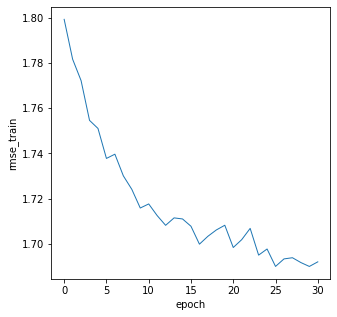

In [17]:
#This will use the affinity matrix to make a neural network for 100k data
#Also, it will print epoch vs rmse graph

with Timer() as train_time:
    model_100k.fit(Xtr_100k)
print("Took {:.2f} seconds for training.".format(train_time.interval))
line_graph(values=model_100k.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [18]:
#This will return top k cecommendations for any user from 100k dataset
#Map back 100k dataframe to affinity matrix for both test and train data

with Timer() as prediction_time:
    top_k_100k =  model_100k.recommend_k_items(Xtst_100k)
print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))
top_k_df_100k = am100k.map_back_sparse(top_k_100k, kind = 'prediction')
test_df_100k = am100k.map_back_sparse(Xtst_100k, kind = 'ratings')

Extracting top 10 elements
Took 0.37 seconds for prediction.


In [19]:
#It will call evaluation functions to show the exact results for 100k data

eval_100k= ranking_metrics(data_size = "mv 100k", data_true =test_df_100k,  data_pred =top_k_df_100k, K=10) 
eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,mv 100k,10,0.142792,0.414968,0.341145,0.215792
